In [3]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [4]:
# Function to clean NaN and infinite values
def clean_data(X_train, X_valid, X_test):
    X_train.fillna(X_train.mean(), inplace=True)
    X_valid.fillna(X_valid.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)
    return X_train, X_valid, X_test

In [5]:
# Load data
data_train = pd.read_pickle("clean_data/train/all_data_train.pkl")
data_valid = pd.read_pickle("clean_data/valid/all_data_valid.pkl")
data_test = pd.read_pickle("clean_data/test/all_data_test.pkl")

In [6]:
# Split the data into features (X) and target (y)
X_train = data_train.drop("class", axis=1)
X_valid = data_valid.drop("class", axis=1)
X_test = data_test.drop("class", axis=1)

y_train = data_train["class"]
y_valid = data_valid["class"]
y_test = data_test["class"]

In [7]:
# Encode the target variable (multi-class encoding)
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_valid = encoder.transform(y_valid)
encoded_y_test = encoder.transform(y_test)

# Clean the data (replace NaNs and infinities)
X_train, X_valid, X_test = clean_data(X_train, X_valid, X_test)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [8]:
# Function to build a model with variable layers and neurons
def build_gru_model2(num_neurons, num_layers, input_shape):
    model = Sequential()
    for _ in range(num_layers):
        model.add(GRU(num_neurons, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(GRU(num_neurons))  # Last layer without return_sequences
    model.add(
        Dense(4, activation="softmax")
    )  # 4 classes for multi-class classification
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model

In [1]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [10]:
# Function to build a model with variable layers and neurons
def build_gru_model(
    num_neurons=32, dropout_rate=0.2, learning_rate=0.001, input_shape=(100, 6)
):
    model = Sequential()
    model.add(GRU(num_neurons, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(GRU(num_neurons))
    model.add(
        Dense(4, activation="softmax")
    )  # 4 classes for multi-class classification
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


# Reshape data for the GRU model
def reshape_data(X, window_length):
    num_features = X.shape[1]
    return X.reshape(X.shape[0], window_length, num_features // window_length)


# Prepare the reshaped data
window_length = 4  # Example window size
X_train_reshaped = reshape_data(X_train, window_length)
X_valid_reshaped = reshape_data(X_valid, window_length)
X_test_reshaped = reshape_data(X_test, window_length)

# Wrap the model in KerasClassifier for GridSearchCV
model = KerasClassifier(
    build_fn=build_gru_model,
    input_shape=(window_length, X_train_reshaped.shape[2]),
    verbose=0,
)

# Define hyperparameter grid for tuning
param_grid = {
    "batch_size": [32, 64],
    "epochs": [10, 20],
    "num_neurons": [32, 64, 128],
    "dropout_rate": [0.2, 0.3, 0.4],
}

# Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_reshaped, encoded_y_train)

# Output the best hyperparameters
print(f"Best Hyperparameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

ValueError: cannot reshape array of size 71874 into shape (11979,4,1)

In [7]:
# Check and adjust the window length based on the number of features
def adjust_window_length(X, window_length):
    num_features = X.shape[1]

    # Ensure the window length does not exceed the number of features
    if window_length > num_features:
        print(
            f"Window length {window_length} is too large for {num_features} features. Adjusting window length."
        )
        window_length = num_features

    if num_features % window_length != 0:
        # Adjust window length to fit the number of features
        new_window_length = num_features // (num_features // window_length)
        print(f"Adjusted window length from {window_length} to {new_window_length}")
        return new_window_length

    return window_length

2024-10-17 11:56:10.278256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/35
120/120 [==============================] - 8s 19ms/step - loss: 1.1826 - accuracy: 0.5180 - val_loss: 0.8744 - val_accuracy: 0.6718
Epoch 2/35
120/120 [==============================] - 1s 7ms/step - loss: 0.6943 - accuracy: 0.7463 - val_loss: 0.4421 - val_accuracy: 0.8513
Epoch 3/35
120/120 [==============================] - 1s 8ms/step - loss: 0.4469 - accuracy: 0.8359 - val_loss: 0.3321 - val_accuracy: 0.8813
Epoch 4/35
120/120 [==============================] - 1s 10ms/step - loss: 0.3778 - accuracy: 0.8599 - val_loss: 0.2965 - val_accuracy: 0.8908
Epoch 5/35
120/120 [==============================] - 2s 14ms/step - loss: 0.3427 - accuracy: 0.8694 - val_loss: 0.2741 - val_accuracy: 0.8993
Epoch 6/35
120/120 [==============================] - 1s 11ms/step - loss: 0.3256 - accuracy: 0.8764 - val_loss: 0.2639 - val_accuracy: 0.9026
Epoch 7/35
120/120 [==============================] - 1s 8ms/step - loss: 0.3116 - accuracy: 0.8805 - val_loss: 0.2604 - val_accuracy: 0.9041
Ep

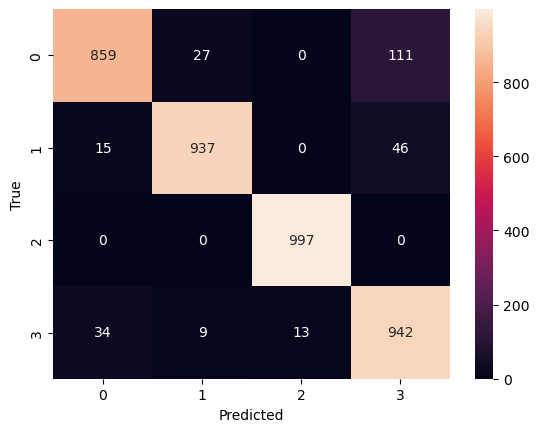

Epoch 1/35
120/120 [==============================] - 8s 19ms/step - loss: 1.1430 - accuracy: 0.5307 - val_loss: 0.6738 - val_accuracy: 0.7682
Epoch 2/35
120/120 [==============================] - 1s 8ms/step - loss: 0.5811 - accuracy: 0.7801 - val_loss: 0.3861 - val_accuracy: 0.8638
Epoch 3/35
120/120 [==============================] - 1s 9ms/step - loss: 0.4252 - accuracy: 0.8396 - val_loss: 0.3084 - val_accuracy: 0.8853
Epoch 4/35
120/120 [==============================] - 1s 9ms/step - loss: 0.3721 - accuracy: 0.8571 - val_loss: 0.2837 - val_accuracy: 0.8916
Epoch 5/35
120/120 [==============================] - 1s 8ms/step - loss: 0.3445 - accuracy: 0.8687 - val_loss: 0.2688 - val_accuracy: 0.8983
Epoch 6/35
120/120 [==============================] - 1s 8ms/step - loss: 0.3259 - accuracy: 0.8780 - val_loss: 0.2595 - val_accuracy: 0.9046
Epoch 7/35
120/120 [==============================] - 1s 9ms/step - loss: 0.3073 - accuracy: 0.8829 - val_loss: 0.2499 - val_accuracy: 0.9054
Epoch

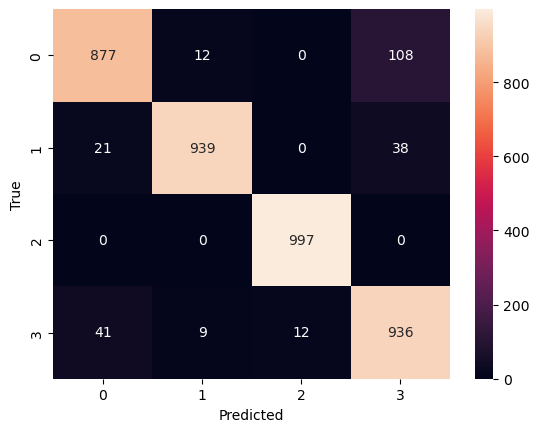

Epoch 1/35
120/120 [==============================] - 6s 19ms/step - loss: 1.0461 - accuracy: 0.5917 - val_loss: 0.5554 - val_accuracy: 0.8255
Epoch 2/35
120/120 [==============================] - 1s 10ms/step - loss: 0.4586 - accuracy: 0.8375 - val_loss: 0.3218 - val_accuracy: 0.8776
Epoch 3/35
120/120 [==============================] - 1s 7ms/step - loss: 0.3393 - accuracy: 0.8716 - val_loss: 0.2927 - val_accuracy: 0.8898
Epoch 4/35
120/120 [==============================] - 1s 7ms/step - loss: 0.3074 - accuracy: 0.8822 - val_loss: 0.2607 - val_accuracy: 0.9039
Epoch 5/35
120/120 [==============================] - 1s 9ms/step - loss: 0.2865 - accuracy: 0.8896 - val_loss: 0.2534 - val_accuracy: 0.9054
Epoch 6/35
120/120 [==============================] - 1s 7ms/step - loss: 0.2707 - accuracy: 0.8940 - val_loss: 0.2404 - val_accuracy: 0.9126
Epoch 7/35
120/120 [==============================] - 1s 8ms/step - loss: 0.2551 - accuracy: 0.9017 - val_loss: 0.2352 - val_accuracy: 0.9084
Epoc

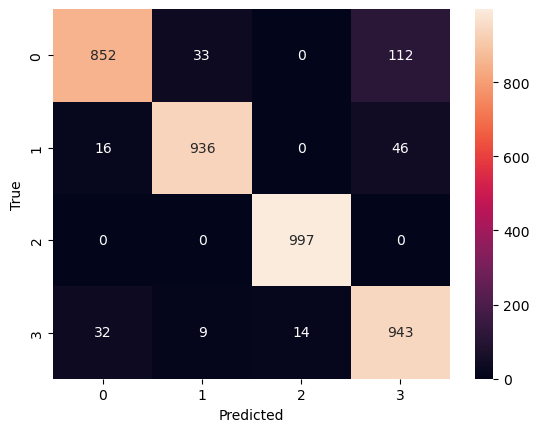

Epoch 1/35
120/120 [==============================] - 8s 21ms/step - loss: 0.9962 - accuracy: 0.6199 - val_loss: 0.4421 - val_accuracy: 0.8408
Epoch 2/35
120/120 [==============================] - 1s 11ms/step - loss: 0.4230 - accuracy: 0.8427 - val_loss: 0.2994 - val_accuracy: 0.8883
Epoch 3/35
120/120 [==============================] - 1s 10ms/step - loss: 0.3521 - accuracy: 0.8643 - val_loss: 0.2803 - val_accuracy: 0.8923
Epoch 4/35
120/120 [==============================] - 1s 11ms/step - loss: 0.3208 - accuracy: 0.8785 - val_loss: 0.2583 - val_accuracy: 0.9026
Epoch 5/35
120/120 [==============================] - 1s 10ms/step - loss: 0.3010 - accuracy: 0.8828 - val_loss: 0.2512 - val_accuracy: 0.9059
Epoch 6/35
120/120 [==============================] - 2s 18ms/step - loss: 0.2830 - accuracy: 0.8923 - val_loss: 0.2445 - val_accuracy: 0.9079
Epoch 7/35
120/120 [==============================] - 2s 15ms/step - loss: 0.2672 - accuracy: 0.8973 - val_loss: 0.2313 - val_accuracy: 0.9089

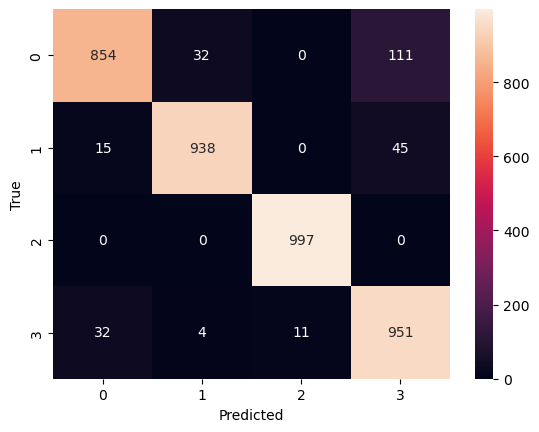

Epoch 1/35
120/120 [==============================] - 7s 24ms/step - loss: 0.9032 - accuracy: 0.6469 - val_loss: 0.3987 - val_accuracy: 0.8593
Epoch 2/35
120/120 [==============================] - 2s 18ms/step - loss: 0.3696 - accuracy: 0.8623 - val_loss: 0.2843 - val_accuracy: 0.8888
Epoch 3/35
120/120 [==============================] - 2s 15ms/step - loss: 0.2971 - accuracy: 0.8855 - val_loss: 0.2551 - val_accuracy: 0.9046
Epoch 4/35
120/120 [==============================] - 2s 15ms/step - loss: 0.2717 - accuracy: 0.8949 - val_loss: 0.2595 - val_accuracy: 0.9051
Epoch 5/35
120/120 [==============================] - 2s 15ms/step - loss: 0.2484 - accuracy: 0.9041 - val_loss: 0.2282 - val_accuracy: 0.9189
Epoch 6/35
120/120 [==============================] - 2s 16ms/step - loss: 0.2332 - accuracy: 0.9094 - val_loss: 0.2167 - val_accuracy: 0.9266
Epoch 7/35
120/120 [==============================] - 2s 15ms/step - loss: 0.2176 - accuracy: 0.9182 - val_loss: 0.2134 - val_accuracy: 0.9281

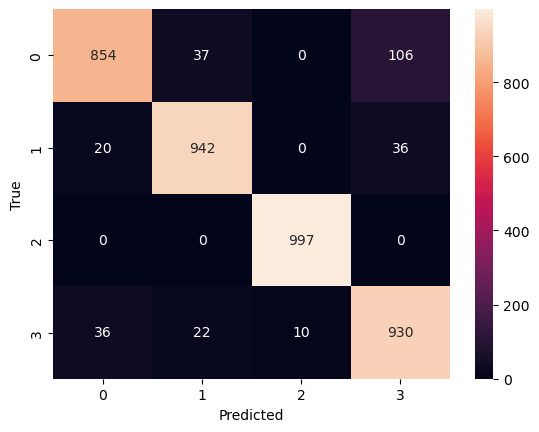

Epoch 1/35
120/120 [==============================] - 11s 40ms/step - loss: 0.8425 - accuracy: 0.6711 - val_loss: 0.3625 - val_accuracy: 0.8686
Epoch 2/35
120/120 [==============================] - 2s 17ms/step - loss: 0.3659 - accuracy: 0.8649 - val_loss: 0.2879 - val_accuracy: 0.8966
Epoch 3/35
120/120 [==============================] - 2s 18ms/step - loss: 0.3056 - accuracy: 0.8800 - val_loss: 0.2527 - val_accuracy: 0.9021
Epoch 4/35
120/120 [==============================] - 2s 17ms/step - loss: 0.2796 - accuracy: 0.8897 - val_loss: 0.2352 - val_accuracy: 0.9086
Epoch 5/35
120/120 [==============================] - 2s 18ms/step - loss: 0.2552 - accuracy: 0.8990 - val_loss: 0.2271 - val_accuracy: 0.9179
Epoch 6/35
120/120 [==============================] - 2s 17ms/step - loss: 0.2415 - accuracy: 0.9055 - val_loss: 0.2190 - val_accuracy: 0.9226
Epoch 7/35
120/120 [==============================] - 2s 17ms/step - loss: 0.2227 - accuracy: 0.9133 - val_loss: 0.2121 - val_accuracy: 0.926

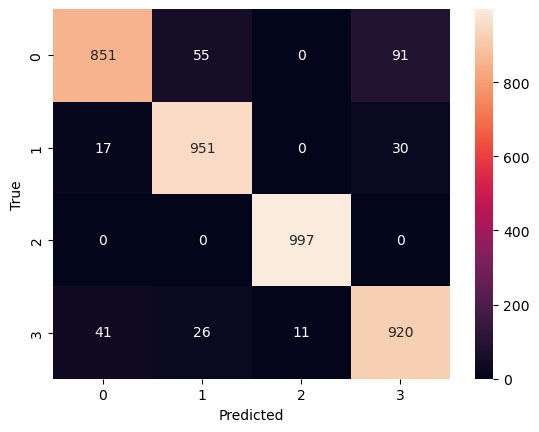

Adjusted window length from 4 to 6
Epoch 1/35
120/120 [==============================] - 8s 26ms/step - loss: 1.0515 - accuracy: 0.5486 - val_loss: 0.6058 - val_accuracy: 0.7641
Epoch 2/35
120/120 [==============================] - 1s 11ms/step - loss: 0.6024 - accuracy: 0.7508 - val_loss: 0.4712 - val_accuracy: 0.8267
Epoch 3/35
120/120 [==============================] - 1s 10ms/step - loss: 0.5220 - accuracy: 0.7873 - val_loss: 0.4104 - val_accuracy: 0.8495
Epoch 4/35
120/120 [==============================] - 1s 11ms/step - loss: 0.4715 - accuracy: 0.8154 - val_loss: 0.3789 - val_accuracy: 0.8580
Epoch 5/35
120/120 [==============================] - 1s 10ms/step - loss: 0.4341 - accuracy: 0.8309 - val_loss: 0.3597 - val_accuracy: 0.8635
Epoch 6/35
120/120 [==============================] - 1s 10ms/step - loss: 0.4062 - accuracy: 0.8418 - val_loss: 0.3422 - val_accuracy: 0.8681
Epoch 7/35
120/120 [==============================] - 1s 11ms/step - loss: 0.3775 - accuracy: 0.8515 - val_

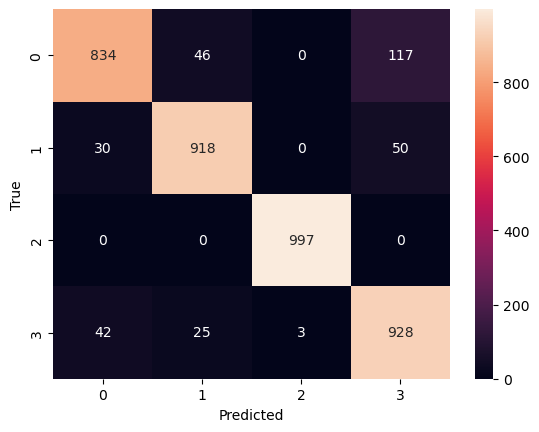

Epoch 1/35
120/120 [==============================] - 10s 25ms/step - loss: 0.9843 - accuracy: 0.5654 - val_loss: 0.6050 - val_accuracy: 0.7574
Epoch 2/35
120/120 [==============================] - 2s 15ms/step - loss: 0.6048 - accuracy: 0.7391 - val_loss: 0.4708 - val_accuracy: 0.8222
Epoch 3/35
120/120 [==============================] - 2s 14ms/step - loss: 0.5238 - accuracy: 0.7837 - val_loss: 0.4235 - val_accuracy: 0.8300
Epoch 4/35
120/120 [==============================] - 2s 15ms/step - loss: 0.4640 - accuracy: 0.8135 - val_loss: 0.3722 - val_accuracy: 0.8508
Epoch 5/35
120/120 [==============================] - 2s 13ms/step - loss: 0.4271 - accuracy: 0.8312 - val_loss: 0.3485 - val_accuracy: 0.8613
Epoch 6/35
120/120 [==============================] - 2s 13ms/step - loss: 0.3972 - accuracy: 0.8436 - val_loss: 0.3309 - val_accuracy: 0.8663
Epoch 7/35
120/120 [==============================] - 2s 15ms/step - loss: 0.3709 - accuracy: 0.8527 - val_loss: 0.3110 - val_accuracy: 0.884

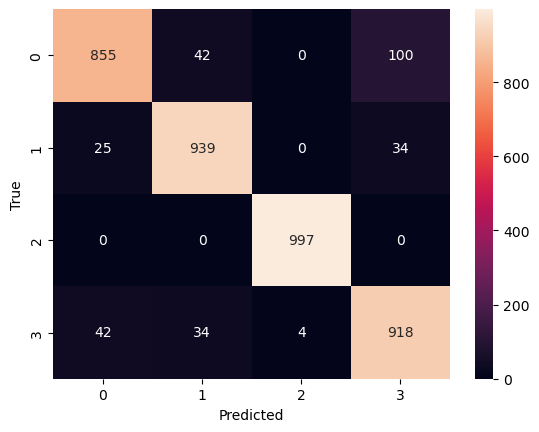

Epoch 1/35
120/120 [==============================] - 7s 21ms/step - loss: 0.8987 - accuracy: 0.6072 - val_loss: 0.5370 - val_accuracy: 0.7859
Epoch 2/35
120/120 [==============================] - 2s 14ms/step - loss: 0.5377 - accuracy: 0.7780 - val_loss: 0.4188 - val_accuracy: 0.8455
Epoch 3/35
120/120 [==============================] - 2s 15ms/step - loss: 0.4414 - accuracy: 0.8279 - val_loss: 0.3642 - val_accuracy: 0.8560
Epoch 4/35
120/120 [==============================] - 2s 13ms/step - loss: 0.3763 - accuracy: 0.8544 - val_loss: 0.3122 - val_accuracy: 0.8871
Epoch 5/35
120/120 [==============================] - 2s 15ms/step - loss: 0.3328 - accuracy: 0.8724 - val_loss: 0.2937 - val_accuracy: 0.8901
Epoch 6/35
120/120 [==============================] - 2s 14ms/step - loss: 0.3051 - accuracy: 0.8852 - val_loss: 0.2822 - val_accuracy: 0.8966
Epoch 7/35
120/120 [==============================] - 2s 13ms/step - loss: 0.2810 - accuracy: 0.8931 - val_loss: 0.2590 - val_accuracy: 0.9064

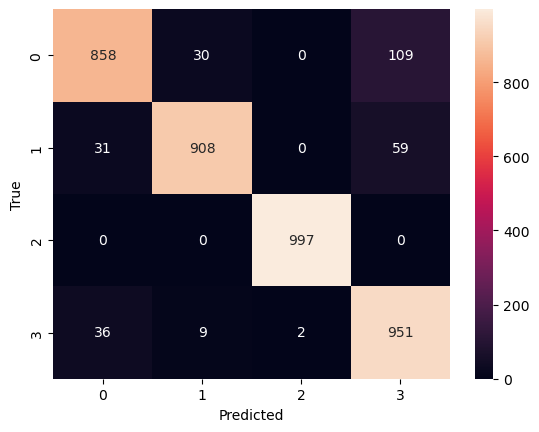

Epoch 1/35
120/120 [==============================] - 10s 31ms/step - loss: 0.8912 - accuracy: 0.6162 - val_loss: 0.5080 - val_accuracy: 0.8042
Epoch 2/35
120/120 [==============================] - 3s 22ms/step - loss: 0.5229 - accuracy: 0.7837 - val_loss: 0.4033 - val_accuracy: 0.8390
Epoch 3/35
120/120 [==============================] - 3s 26ms/step - loss: 0.4255 - accuracy: 0.8335 - val_loss: 0.3511 - val_accuracy: 0.8613
Epoch 4/35
120/120 [==============================] - 2s 19ms/step - loss: 0.3598 - accuracy: 0.8568 - val_loss: 0.2969 - val_accuracy: 0.8878
Epoch 5/35
120/120 [==============================] - 2s 20ms/step - loss: 0.3189 - accuracy: 0.8744 - val_loss: 0.2665 - val_accuracy: 0.9026
Epoch 6/35
120/120 [==============================] - 2s 20ms/step - loss: 0.2947 - accuracy: 0.8860 - val_loss: 0.2599 - val_accuracy: 0.9016
Epoch 7/35
120/120 [==============================] - 3s 21ms/step - loss: 0.2757 - accuracy: 0.8952 - val_loss: 0.2467 - val_accuracy: 0.909

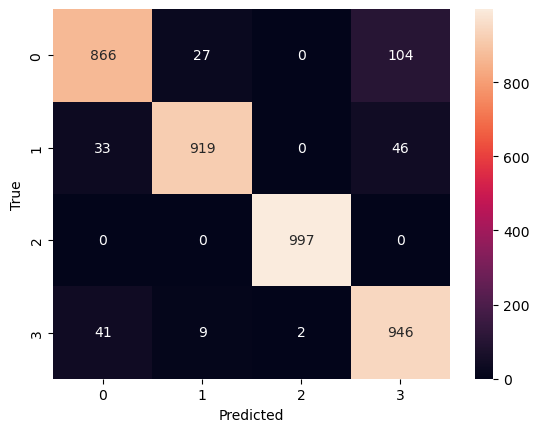

Epoch 1/35
120/120 [==============================] - 11s 37ms/step - loss: 0.8297 - accuracy: 0.6380 - val_loss: 0.4873 - val_accuracy: 0.8115
Epoch 2/35
120/120 [==============================] - 3s 27ms/step - loss: 0.4825 - accuracy: 0.8049 - val_loss: 0.3750 - val_accuracy: 0.8555
Epoch 3/35
120/120 [==============================] - 4s 29ms/step - loss: 0.3802 - accuracy: 0.8506 - val_loss: 0.2986 - val_accuracy: 0.8896
Epoch 4/35
120/120 [==============================] - 4s 34ms/step - loss: 0.3064 - accuracy: 0.8818 - val_loss: 0.2552 - val_accuracy: 0.9096
Epoch 5/35
120/120 [==============================] - 3s 29ms/step - loss: 0.2702 - accuracy: 0.8969 - val_loss: 0.2571 - val_accuracy: 0.9044
Epoch 6/35
120/120 [==============================] - 4s 30ms/step - loss: 0.2463 - accuracy: 0.9077 - val_loss: 0.2268 - val_accuracy: 0.9219
Epoch 7/35
120/120 [==============================] - 4s 31ms/step - loss: 0.2306 - accuracy: 0.9149 - val_loss: 0.2260 - val_accuracy: 0.919

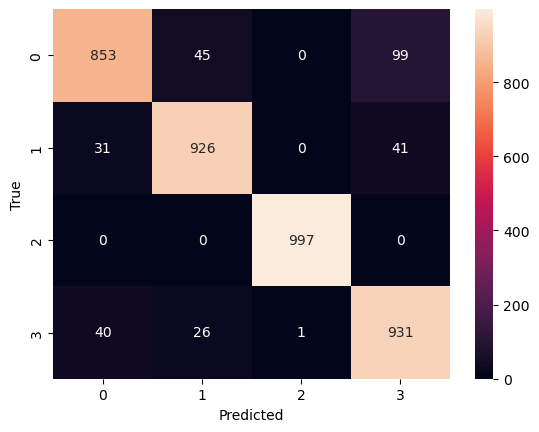

Epoch 1/35
120/120 [==============================] - 20s 63ms/step - loss: 0.7774 - accuracy: 0.6634 - val_loss: 0.4318 - val_accuracy: 0.8388
Epoch 2/35
120/120 [==============================] - 6s 51ms/step - loss: 0.4520 - accuracy: 0.8190 - val_loss: 0.3335 - val_accuracy: 0.8638
Epoch 3/35
120/120 [==============================] - 10s 83ms/step - loss: 0.3538 - accuracy: 0.8583 - val_loss: 0.3135 - val_accuracy: 0.8811
Epoch 4/35
120/120 [==============================] - 12s 100ms/step - loss: 0.2985 - accuracy: 0.8826 - val_loss: 0.2593 - val_accuracy: 0.9106
Epoch 5/35
120/120 [==============================] - 6s 47ms/step - loss: 0.2632 - accuracy: 0.8998 - val_loss: 0.2416 - val_accuracy: 0.9156
Epoch 6/35
120/120 [==============================] - 5s 46ms/step - loss: 0.2430 - accuracy: 0.9093 - val_loss: 0.2257 - val_accuracy: 0.9199
Epoch 7/35
120/120 [==============================] - 7s 60ms/step - loss: 0.2203 - accuracy: 0.9152 - val_loss: 0.2266 - val_accuracy: 0.

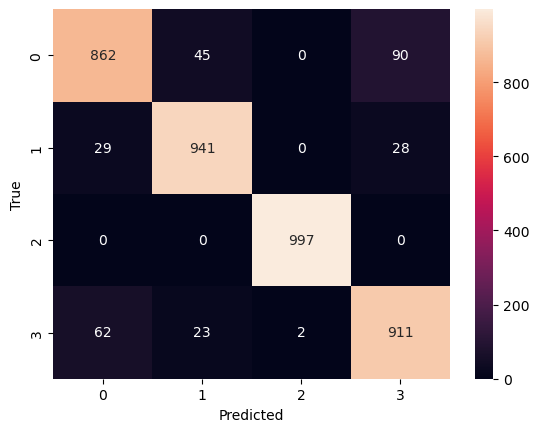

Epoch 1/35
120/120 [==============================] - 7s 20ms/step - loss: 0.9986 - accuracy: 0.5669 - val_loss: 0.6132 - val_accuracy: 0.7614
Epoch 2/35
120/120 [==============================] - 1s 12ms/step - loss: 0.6105 - accuracy: 0.7388 - val_loss: 0.4961 - val_accuracy: 0.8162
Epoch 3/35
120/120 [==============================] - 1s 11ms/step - loss: 0.5355 - accuracy: 0.7758 - val_loss: 0.4260 - val_accuracy: 0.8428
Epoch 4/35
120/120 [==============================] - 2s 14ms/step - loss: 0.4812 - accuracy: 0.8089 - val_loss: 0.3896 - val_accuracy: 0.8523
Epoch 5/35
120/120 [==============================] - 1s 11ms/step - loss: 0.4414 - accuracy: 0.8290 - val_loss: 0.3712 - val_accuracy: 0.8548
Epoch 6/35
120/120 [==============================] - 1s 10ms/step - loss: 0.4079 - accuracy: 0.8404 - val_loss: 0.3428 - val_accuracy: 0.8600
Epoch 7/35
120/120 [==============================] - 1s 11ms/step - loss: 0.3796 - accuracy: 0.8527 - val_loss: 0.3280 - val_accuracy: 0.8716

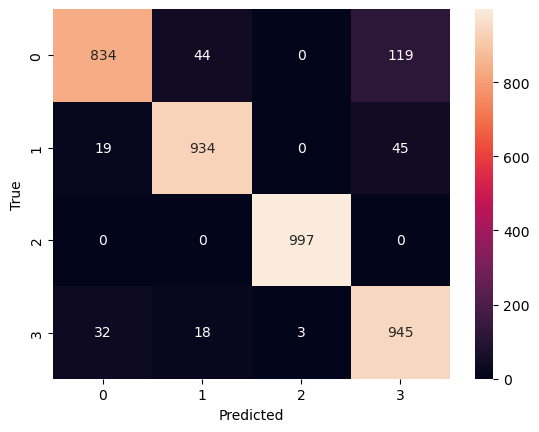

Epoch 1/35
120/120 [==============================] - 11s 27ms/step - loss: 0.9856 - accuracy: 0.5702 - val_loss: 0.5863 - val_accuracy: 0.7621
Epoch 2/35
120/120 [==============================] - 2s 14ms/step - loss: 0.6082 - accuracy: 0.7410 - val_loss: 0.4766 - val_accuracy: 0.8182
Epoch 3/35
120/120 [==============================] - 2s 15ms/step - loss: 0.5353 - accuracy: 0.7818 - val_loss: 0.4392 - val_accuracy: 0.8247
Epoch 4/35
120/120 [==============================] - 2s 14ms/step - loss: 0.4753 - accuracy: 0.8113 - val_loss: 0.3747 - val_accuracy: 0.8533
Epoch 5/35
120/120 [==============================] - 2s 13ms/step - loss: 0.4365 - accuracy: 0.8291 - val_loss: 0.3539 - val_accuracy: 0.8580
Epoch 6/35
120/120 [==============================] - 2s 16ms/step - loss: 0.3988 - accuracy: 0.8442 - val_loss: 0.3328 - val_accuracy: 0.8681
Epoch 7/35
120/120 [==============================] - 2s 20ms/step - loss: 0.3661 - accuracy: 0.8573 - val_loss: 0.3188 - val_accuracy: 0.872

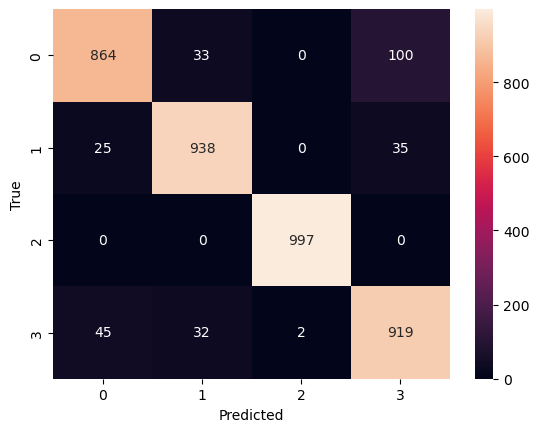

Epoch 1/35
120/120 [==============================] - 7s 28ms/step - loss: 0.9360 - accuracy: 0.5904 - val_loss: 0.5672 - val_accuracy: 0.7634
Epoch 2/35
120/120 [==============================] - 2s 21ms/step - loss: 0.5559 - accuracy: 0.7643 - val_loss: 0.4164 - val_accuracy: 0.8455
Epoch 3/35
120/120 [==============================] - 3s 28ms/step - loss: 0.4565 - accuracy: 0.8144 - val_loss: 0.3644 - val_accuracy: 0.8555
Epoch 4/35
120/120 [==============================] - 2s 17ms/step - loss: 0.3895 - accuracy: 0.8466 - val_loss: 0.3220 - val_accuracy: 0.8726
Epoch 5/35
120/120 [==============================] - 2s 19ms/step - loss: 0.3422 - accuracy: 0.8651 - val_loss: 0.2957 - val_accuracy: 0.8868
Epoch 6/35
120/120 [==============================] - 3s 28ms/step - loss: 0.3074 - accuracy: 0.8817 - val_loss: 0.2680 - val_accuracy: 0.9001
Epoch 7/35
120/120 [==============================] - 2s 19ms/step - loss: 0.2880 - accuracy: 0.8880 - val_loss: 0.2591 - val_accuracy: 0.9051

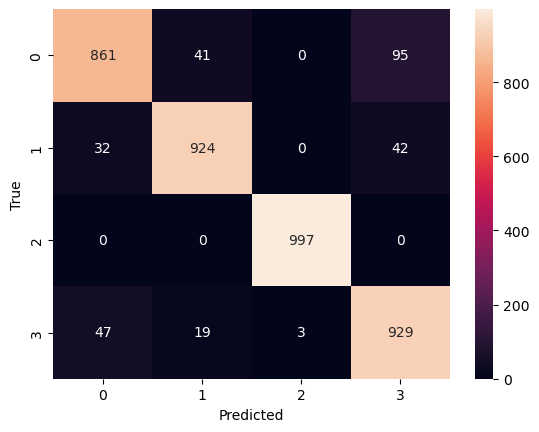

Epoch 1/35
120/120 [==============================] - 10s 34ms/step - loss: 0.8575 - accuracy: 0.6193 - val_loss: 0.5185 - val_accuracy: 0.7877
Epoch 2/35
120/120 [==============================] - 2s 21ms/step - loss: 0.5307 - accuracy: 0.7792 - val_loss: 0.3898 - val_accuracy: 0.8493
Epoch 3/35
120/120 [==============================] - 3s 22ms/step - loss: 0.4334 - accuracy: 0.8285 - val_loss: 0.3679 - val_accuracy: 0.8540
Epoch 4/35
120/120 [==============================] - 3s 21ms/step - loss: 0.3771 - accuracy: 0.8530 - val_loss: 0.3215 - val_accuracy: 0.8743
Epoch 5/35
120/120 [==============================] - 2s 20ms/step - loss: 0.3244 - accuracy: 0.8748 - val_loss: 0.2827 - val_accuracy: 0.8966
Epoch 6/35
120/120 [==============================] - 3s 23ms/step - loss: 0.2949 - accuracy: 0.8841 - val_loss: 0.2665 - val_accuracy: 0.9039
Epoch 7/35
120/120 [==============================] - 3s 22ms/step - loss: 0.2734 - accuracy: 0.8963 - val_loss: 0.2358 - val_accuracy: 0.914

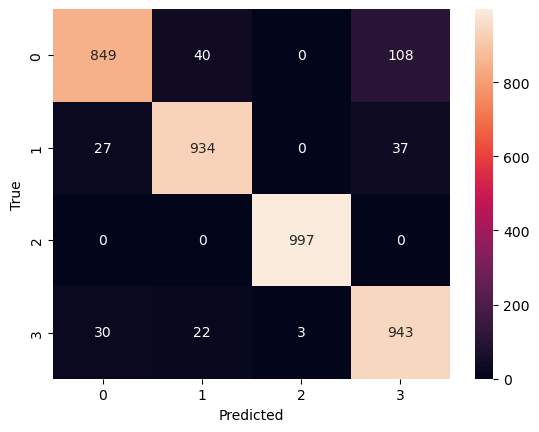

Epoch 1/35
120/120 [==============================] - 141s 84ms/step - loss: 0.8157 - accuracy: 0.6372 - val_loss: 0.4794 - val_accuracy: 0.8102
Epoch 2/35
120/120 [==============================] - 3s 28ms/step - loss: 0.4736 - accuracy: 0.8068 - val_loss: 0.3622 - val_accuracy: 0.8603
Epoch 3/35
120/120 [==============================] - 4s 31ms/step - loss: 0.3670 - accuracy: 0.8539 - val_loss: 0.2954 - val_accuracy: 0.8848
Epoch 4/35
120/120 [==============================] - 3s 27ms/step - loss: 0.3031 - accuracy: 0.8815 - val_loss: 0.2621 - val_accuracy: 0.9101
Epoch 5/35
120/120 [==============================] - 3s 25ms/step - loss: 0.2695 - accuracy: 0.8977 - val_loss: 0.2416 - val_accuracy: 0.9156
Epoch 6/35
120/120 [==============================] - 3s 29ms/step - loss: 0.2481 - accuracy: 0.9043 - val_loss: 0.2345 - val_accuracy: 0.9126
Epoch 7/35
120/120 [==============================] - 4s 33ms/step - loss: 0.2260 - accuracy: 0.9140 - val_loss: 0.2201 - val_accuracy: 0.92

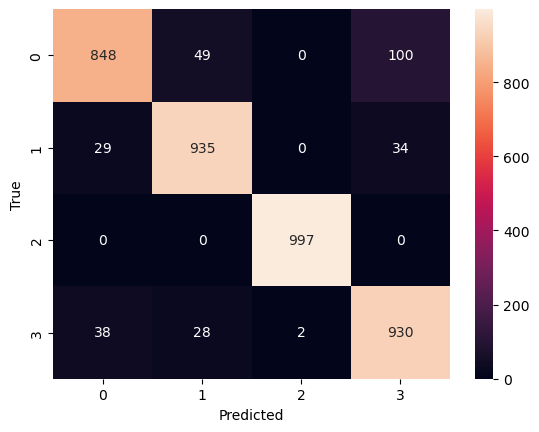

Epoch 1/35
120/120 [==============================] - 17s 92ms/step - loss: 0.7907 - accuracy: 0.6551 - val_loss: 0.4712 - val_accuracy: 0.8050
Epoch 2/35
120/120 [==============================] - 5s 43ms/step - loss: 0.4655 - accuracy: 0.8118 - val_loss: 0.3868 - val_accuracy: 0.8373
Epoch 3/35
120/120 [==============================] - 5s 44ms/step - loss: 0.3668 - accuracy: 0.8557 - val_loss: 0.2934 - val_accuracy: 0.8878
Epoch 4/35
120/120 [==============================] - 7s 56ms/step - loss: 0.3046 - accuracy: 0.8830 - val_loss: 0.2726 - val_accuracy: 0.8988
Epoch 5/35
120/120 [==============================] - 7s 62ms/step - loss: 0.2692 - accuracy: 0.8977 - val_loss: 0.2537 - val_accuracy: 0.9074
Epoch 6/35
120/120 [==============================] - 5s 42ms/step - loss: 0.2408 - accuracy: 0.9092 - val_loss: 0.2513 - val_accuracy: 0.9106
Epoch 7/35
120/120 [==============================] - 5s 43ms/step - loss: 0.2258 - accuracy: 0.9137 - val_loss: 0.2443 - val_accuracy: 0.910

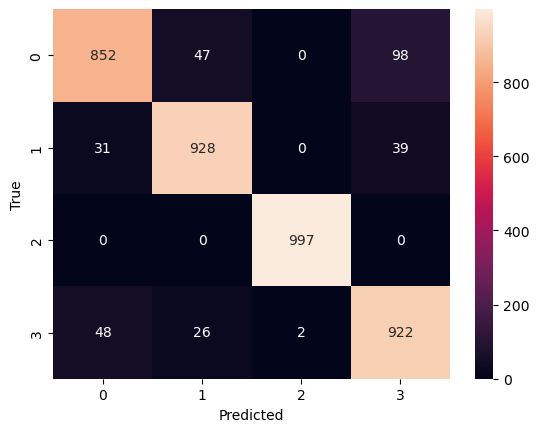

Best model validation accuracy: 0.94


In [8]:
best_accuracy = 0.0
best_model = None

# Experiment with different window lengths and number of neurons/layers
window_lengths = [2, 4, 6]  # Example window sizes
num_neurons_list = [32, 64, 128]  # Different neuron sizes
num_layers_list = [1, 2]  # Different number of layers

for window_length in window_lengths:
    # Adjust window length based on the feature size
    window_length = adjust_window_length(X_train, window_length)

    # Ensure the reshaping can happen correctly
    X_train_reshaped = X_train.reshape(
        X_train.shape[0], window_length, X_train.shape[1] // window_length
    )
    X_valid_reshaped = X_valid.reshape(
        X_valid.shape[0], window_length, X_valid.shape[1] // window_length
    )
    X_test_reshaped = X_test.reshape(
        X_test.shape[0], window_length, X_test.shape[1] // window_length
    )

    for num_neurons in num_neurons_list:
        for num_layers in num_layers_list:
            model = build_gru_model(
                num_neurons, num_layers, (window_length, X_train_reshaped.shape[2])
            )

            # Fit the model
            model.fit(
                X_train_reshaped,
                encoded_y_train,
                epochs=35,
                batch_size=100,
                validation_data=(X_valid_reshaped, encoded_y_valid),
            )

            # Evaluate the model
            _, accuracy = model.evaluate(X_valid_reshaped, encoded_y_valid)
            print(
                f"Window: {window_length}, Neurons: {num_neurons}, Layers: {num_layers}, Validation Accuracy: {accuracy:.2f}"
            )

            # Check if this is the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                # Save the best model
                model.save("best_gru_model.h5")

            # Predict the test data
            y_pred = model.predict(X_test_reshaped)
            y_pred = np.argmax(y_pred, axis=1)

            # Create confusion matrix
            cm = confusion_matrix(encoded_y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt="g")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()

# Load the best model for later use
best_model = load_model("best_gru_model.h5")
print(f"Best model validation accuracy: {best_accuracy:.2f}")

In [28]:
# Load new 1-minute data for prediction


def combine_pickles_with_class(path, class_name):
    # Initialize lists to hold acc and gyro files
    acc_files = []
    gyro_files = []

    # List all files in the directory
    for file in os.listdir(path):
        if file.startswith(class_name) and file.endswith("_acc.pkl"):
            acc_files.append(file)
        elif file.startswith(class_name) and file.endswith("_gyro.pkl"):
            gyro_files.append(file)

    # Create a list to hold the combined data for all the files
    combined_data_list = []

    # Rename columns appropriately for acc and gyro DataFrames
    for i in range(len(acc_files)):
        acc_df = pd.read_pickle(path + acc_files[i])
        gyro_df = pd.read_pickle(path + gyro_files[i])

        # Drop the first column (assumed to be an index or unneeded)

        # if num of columns is 4, then drop the first column
        if len(acc_df.columns) == 4:
            acc_df.drop(acc_df.columns[0], axis=1, inplace=True)
            gyro_df.drop(gyro_df.columns[0], axis=1, inplace=True)

        # Rename columns
        acc_df.columns = ["ax", "ay", "az"]
        gyro_df.columns = ["gx", "gy", "gz"]

        # Combine acc and gyro DataFrames horizontally
        combined_df = pd.concat([acc_df, gyro_df], axis=1)

        # # Add class column
        # combined_df["class"] = class_name

        # # Append the combined DataFrame to the list
        combined_data_list.append(combined_df)

    # Concatenate all DataFrames vertically to get the final combined DataFrame
    final_df = pd.concat(combined_data_list, ignore_index=True)

    return final_df


# test the function

In [29]:
# Load the best saved model
best_model = load_model("best_gru_model.h5")

# Load new data
new_data = combine_pickles_with_class("newdata/", "data")

# Apply the same scaler used earlier (assuming the scaler is already fitted)
new_data_scaled = scaler.transform(new_data)

# Reshape the new data based on the same window_length used in training
new_data_reshaped = new_data_scaled.reshape(
    new_data_scaled.shape[0], window_length, new_data_scaled.shape[1] // window_length
)

# Predict on the new data using the best model
new_pred = best_model.predict(new_data_reshaped)

# Get the predicted classes
new_pred_classes = np.argmax(new_pred, axis=1)

# Now you can work with new_pred_classes, which contains the predictions for the new data
print(new_pred_classes)

250/250 [==============================] - 4s 16ms/step


In [35]:
new_pred.shape

(7981, 4)

In [30]:
new_data.head()

,ax,ay,az,gx,gy,gz
0,3.950734,9.491013,0.552351,-0.425043,0.388124,0.519434
1,3.212619,9.993668,0.108075,-0.357386,0.326105,0.766726
2,2.621648,10.544523,0.529000,-0.235880,0.480572,1.073316
3,2.145039,11.045531,1.254990,-0.128082,0.858053,1.413990
4,1.873654,11.362272,1.586401,-0.078937,1.375765,1.791496


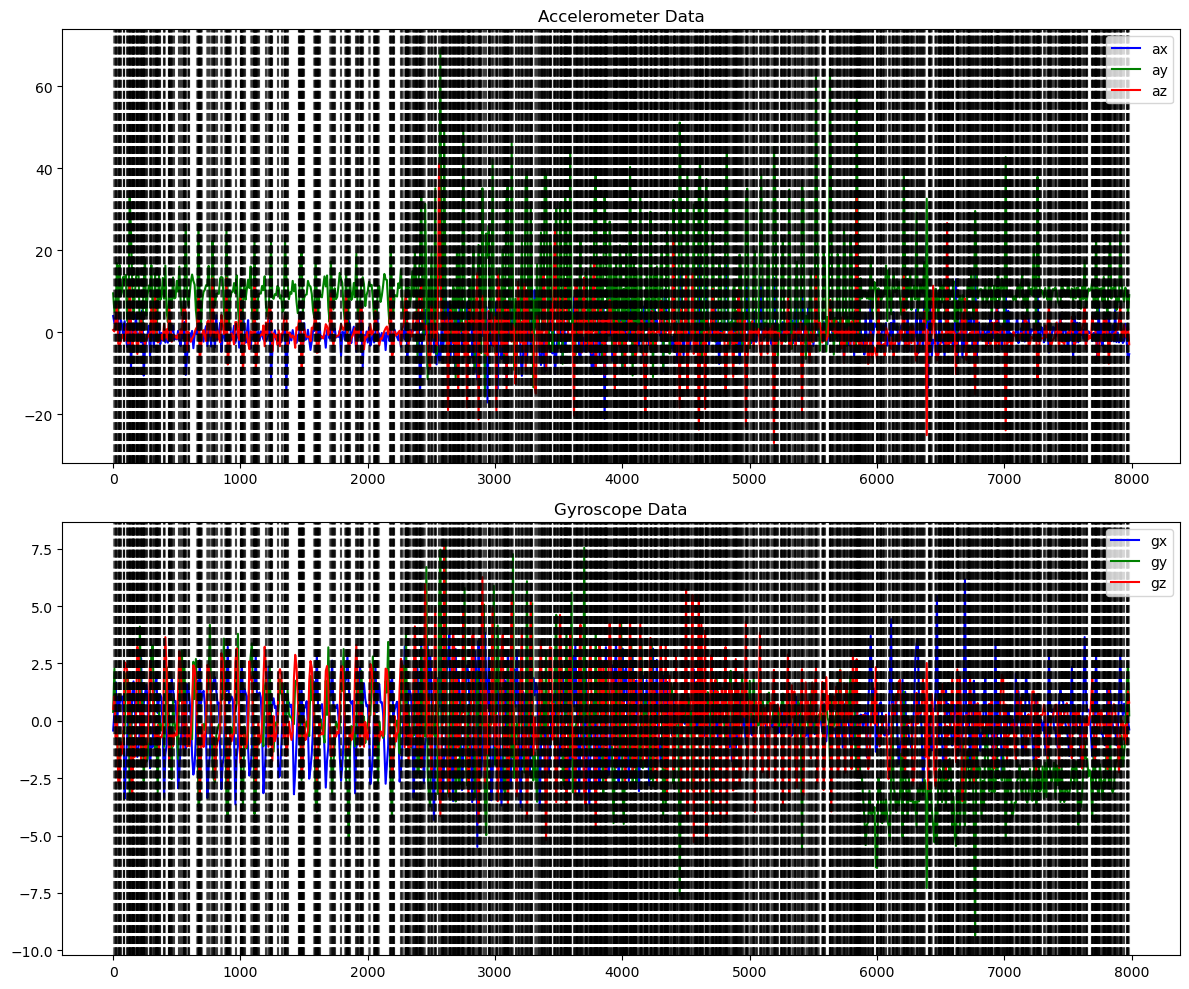

In [31]:
# Calculate class changes to reduce marker clutter
class_changes = [
    i
    for i in range(1, len(new_pred_classes))
    if new_pred_classes[i - 1] != new_pred_classes[i]
]

# Plot the data with reduced markers and increased line width
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Accelerometer Data Plot
for axis, color in zip(["ax", "ay", "az"], ["b", "g", "r"]):
    ax[0].plot(
        new_data.index[::10],
        new_data[axis][::10],
        label=axis,
        color=color,
        linewidth=1.5,
    )  # Plot every 10th point
ax[0].set_title("Accelerometer Data")
ax[0].legend(loc="upper right")

# Gyroscope Data Plot
for axis, color in zip(["gx", "gy", "gz"], ["b", "g", "r"]):
    ax[1].plot(
        new_data.index[::10],
        new_data[axis][::10],
        label=axis,
        color=color,
        linewidth=1.5,
    )  # Plot every 10th point
ax[1].set_title("Gyroscope Data")
ax[1].legend(loc="upper right")

# Adding vertical lines only at points of class change
for change_index in class_changes:
    ax[0].axvline(x=new_data.index[change_index], color="k", linestyle="--", alpha=0.5)
    ax[1].axvline(x=new_data.index[change_index], color="k", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [32]:
def summarize_classifications(predictions):
    start_index = 0
    current_class = predictions[0]
    results = []

    for i in range(1, len(predictions)):
        if predictions[i] != current_class:
            results.append(f"Indices {start_index}-{i - 1}: Class {current_class}")
            start_index = i
            current_class = predictions[i]

    # Don't forget to append the last range
    if start_index < len(predictions):
        results.append(
            f"Indices {start_index}-{len(predictions) - 1}: Class {current_class}"
        )

    return results


# Applying the function to the predictions
classification_summary = summarize_classifications(new_pred_classes)
for line in classification_summary:
    print(line)

Indices 0-2: Class 0
Indices 3-17: Class 3
Indices 18-18: Class 0
Indices 19-22: Class 3
Indices 23-24: Class 0
Indices 25-29: Class 1
Indices 30-38: Class 3
Indices 39-43: Class 1
Indices 44-45: Class 3
Indices 46-46: Class 1
Indices 47-49: Class 3
Indices 50-51: Class 1
Indices 52-62: Class 3
Indices 63-64: Class 1
Indices 65-82: Class 3
Indices 83-83: Class 0
Indices 84-85: Class 1
Indices 86-87: Class 0
Indices 88-109: Class 3
Indices 110-111: Class 0
Indices 112-112: Class 3
Indices 113-116: Class 0
Indices 117-121: Class 3
Indices 122-123: Class 0
Indices 124-129: Class 1
Indices 130-131: Class 0
Indices 132-133: Class 3
Indices 134-135: Class 0
Indices 136-141: Class 1
Indices 142-145: Class 3
Indices 146-146: Class 1
Indices 147-150: Class 3
Indices 151-151: Class 1
Indices 152-152: Class 3
Indices 153-155: Class 0
Indices 156-158: Class 3
Indices 159-159: Class 1
Indices 160-160: Class 0
Indices 161-161: Class 3
Indices 162-164: Class 0
Indices 165-166: Class 1
Indices 167-176

In [36]:
classification_summary = summarize_classifications(y_pred)
for line in classification_summary:
    print(line)

Indices 0-4: Class 3
Indices 5-31: Class 0
Indices 32-32: Class 3
Indices 33-46: Class 0
Indices 47-47: Class 1
Indices 48-52: Class 0
Indices 53-58: Class 3
Indices 59-89: Class 0
Indices 90-91: Class 3
Indices 92-102: Class 0
Indices 103-103: Class 1
Indices 104-108: Class 0
Indices 109-109: Class 1
Indices 110-115: Class 3
Indices 116-144: Class 0
Indices 145-147: Class 3
Indices 148-164: Class 0
Indices 165-170: Class 3
Indices 171-200: Class 0
Indices 201-202: Class 3
Indices 203-206: Class 0
Indices 207-207: Class 1
Indices 208-220: Class 0
Indices 221-224: Class 3
Indices 225-226: Class 1
Indices 227-248: Class 0
Indices 249-250: Class 3
Indices 251-259: Class 0
Indices 260-261: Class 3
Indices 262-268: Class 0
Indices 269-271: Class 1
Indices 272-280: Class 0
Indices 281-282: Class 3
Indices 283-317: Class 0
Indices 318-318: Class 3
Indices 319-335: Class 0
Indices 336-336: Class 1
Indices 337-338: Class 3
Indices 339-374: Class 0
Indices 375-375: Class 3
Indices 376-384: Class